<a href="https://colab.research.google.com/github/srivatsan88/model-deployment/blob/master/Tensorflow_Model_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is demonstrated in video - https://www.youtube.com/watch?v=HOG-o8fbOLk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls -alrt '/content/drive/My Drive/Colab Notebooks/models/'

total 395512
-rw------- 1 root root    578877 Feb 24 22:56 sa_encoder.vocab.tokens1
-rw------- 1 root root 118632960 Feb 24 22:56 sentiment_analysis.hdf51
-rw------- 1 root root 118625184 Feb 24 23:00 final_sentiment_analysis.hdf5
-rw------- 1 root root    578877 Feb 26 23:11 sa_encoder.vocab.tokens
-rw------- 1 root root 118625184 Feb 26 23:11 sentiment_analysis.hdf5
-rw------- 1 root root  33334280 Feb 29 01:40 fashion.hdf5
-rw------- 1 root root  14627584 Feb 29 02:11 fashion_tpu.hdf5


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


TensorFlow 2.x selected.


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/models/fashion_tpu.hdf5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         2

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
model_size = len(tflite_model) / 1024
print('model size = %dKBs.' % model_size)

model size = 4742KBs.


In [ ]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8
#converter.representative_dataset = dataset_gen
tflite_quantized_model = converter.convert()

In [ ]:
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)

Quantized model size = 1193KBs,


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
x_test = np.expand_dims(x_test, -1)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_tensor_index = interpreter.get_input_details()[0]["index"]
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

In [ ]:
interpreter.get_tensor_details()

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'shape': array([ 1, 10], dtype=int32)},
 {'dtype': numpy.float32,
  'index': 1,
  'name': 'conv2d_input',
  'quantization': (0.0, 0),
  'shape': array([ 1, 28, 28,  1], dtype=int32)},
 {'dtype': numpy.float32,
  'index': 2,
  'name': 'sequential/activation/Relu',
  'quantization': (0.0, 0),
  'shape': array([  1, 512], dtype=int32)},
 {'dtype': numpy.float32,
  'index': 3,
  'name': 'sequential/conv2d/Conv2D/ReadVariableOp',
  'quantization': (0.0, 0),
  'shape': array([ 1,  5,  5, 32], dtype=int32)},
 {'dtype': numpy.float32,
  'index': 4,
  'name': 'sequential/conv2d/Conv2D_bias',
  'quantization': (0.0, 0),
  'shape': array([32], dtype=int32)},
 {'dtype': numpy.float32,
  'index': 5,
  'name': 'sequential/conv2d/Relu',
  'quantization': (0.0, 0),
  'shape': array([ 1, 28, 28, 32], dtype=int32)},
 {'dtype': numpy.float32,
  'index': 6,
  'name': 'sequential/conv2d_1/Conv2D/ReadVariableOp',
  '

In [ ]:
all_layers=interpreter.get_tensor_details()
for layer in all_layers:
  #print(layer)
  print(interpreter.get_tensor(layer['index']))

[[-5.4130362e+14  1.0239781e-16  4.5200916e-25  2.1715479e-23
  -7.3947251e+11 -4.0708113e+34  1.4335936e-36  2.9461625e-26
   5.1464081e-19 -2.6825195e+18]]
[[[[ 0.00000000e+00]
   [ 0.00000000e+00]
   [-7.12967019e+23]
   [-6.27751075e+35]
   [ 6.85388949e-15]
   [ 2.25968850e-38]
   [-9.34057569e+15]
   [ 2.26670301e-17]
   [-3.76916764e+37]
   [ 3.04260953e+18]
   [-1.71873911e+11]
   [ 5.08386466e-33]
   [-4.98770176e+08]
   [-2.95226039e+15]
   [-2.13020463e+35]
   [-1.91680665e+24]
   [ 1.44634372e-13]
   [ 3.61570145e-20]
   [ 8.60267679e-09]
   [-1.95566420e+14]
   [-4.92094955e+28]
   [ 6.37919709e-21]
   [ 5.55070651e-27]
   [ 8.96462765e-12]
   [ 8.73997101e-27]
   [ 1.63502384e-39]
   [-6.93921229e+29]
   [ 4.20630473e-37]]

  [[ 3.05559619e-29]
   [-1.10128802e+13]
   [ 9.15803298e-15]
   [-2.97280704e+18]
   [-1.61850958e+23]
   [-3.54817320e+16]
   [ 2.79811557e-14]
   [-2.38864306e+27]
   [-3.89576745e+10]
   [-3.38443869e+12]
   [-3.38758157e+28]
   [ 2.30323337e-03]


In [ ]:
first_layer = model.layers[0]
weights = first_layer.get_weights()[0]
weights

array([[[[ 6.54091090e-02, -1.44164469e-02, -6.22775890e-02,
          -9.84445438e-02,  4.11604457e-02, -6.34526834e-02,
          -6.51369095e-02, -1.49144068e-01, -6.34589419e-02,
          -1.22003220e-02,  1.17760800e-01, -2.62500554e-01,
           5.70577271e-02,  2.57249195e-02,  3.19331302e-03,
           2.33443454e-02,  3.48725468e-02,  2.04648469e-02,
           1.78501885e-02, -5.79638593e-02, -1.09953485e-01,
           5.14385179e-02,  4.93062288e-02, -4.69039902e-02,
          -1.12534631e-02, -7.75886253e-02, -5.45264445e-02,
           3.09129879e-02, -3.40520940e-03, -6.52893633e-02,
          -9.33820531e-02, -2.52439324e-02]],

        [[-7.78269246e-02, -1.05354406e-01,  7.43434802e-02,
          -8.39807913e-02,  4.88188900e-02,  3.38614658e-02,
           4.35198145e-03,  4.53967191e-02, -2.89937183e-02,
          -6.40673861e-02, -7.60272667e-02, -8.96900073e-02,
          -6.58178777e-02,  8.07554126e-02, -6.71230406e-02,
           4.57071401e-02, -5.01382835

In [ ]:
prediction_output = []
for test_image in x_test:

    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    interpreter.invoke()

    out = np.argmax(output()[0])
    prediction_output.append(out)



In [ ]:
accurate_count = 0
for index in range(len(prediction_output)):
  if prediction_output[index] == y_test[index]:
    accurate_count += 1
accuracy = accurate_count * 1.0 / len(prediction_output)

In [ ]:
print(accuracy)

0.916


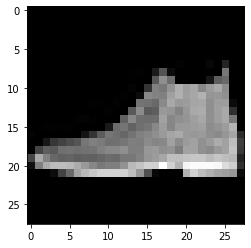

Acutual label: 9
Tensorflow Regular Model: 9
Tensorflow Quantization Model: 9


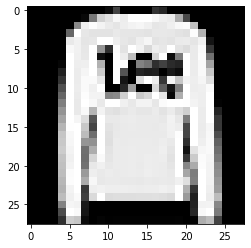

Acutual label: 2
Tensorflow Regular Model: 2
Tensorflow Quantization Model: 2


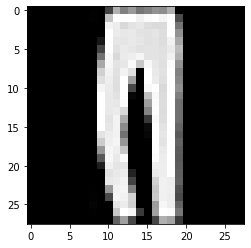

Acutual label: 1
Tensorflow Regular Model: 1
Tensorflow Quantization Model: 1


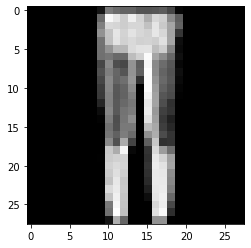

Acutual label: 1
Tensorflow Regular Model: 1
Tensorflow Quantization Model: 1


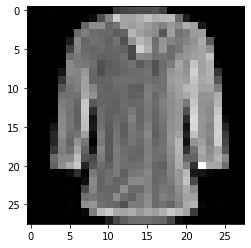

Acutual label: 6
Tensorflow Regular Model: 6
Tensorflow Quantization Model: 6


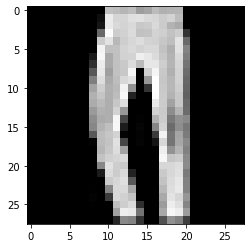

Acutual label: 1
Tensorflow Regular Model: 1
Tensorflow Quantization Model: 1


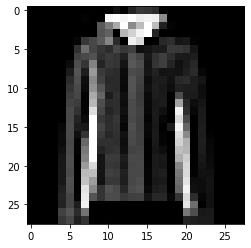

Acutual label: 4
Tensorflow Regular Model: 4
Tensorflow Quantization Model: 4


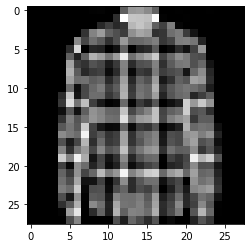

Acutual label: 6
Tensorflow Regular Model: 6
Tensorflow Quantization Model: 6


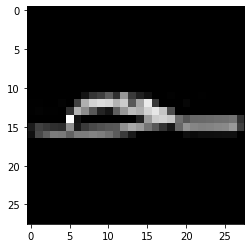

Acutual label: 5
Tensorflow Regular Model: 5
Tensorflow Quantization Model: 5


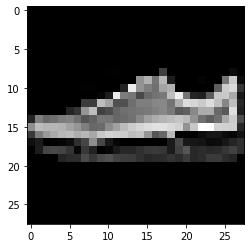

Acutual label: 7
Tensorflow Regular Model: 7
Tensorflow Quantization Model: 7


In [ ]:
index=0
for test_image in x_test[:10]:
  img = np.expand_dims(test_image, axis=0)
  tf_prediction=model.predict(img)
  plt.figure()
  plt.imshow(img[0, :,:, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
  plt.show()
  print("Acutual label: %s" % y_test[index])
  print("Tensorflow Regular Model: %d" % np.argmax(tf_prediction))
  print("Tensorflow Quantization Model: %d" % prediction_output[index])
  index=index+1


In [ ]:
import time
start_time = time.time()

for test_image in x_test:

    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    interpreter.invoke()

print("Total Quantization Predict Time: %s seconds" % (str(time.time() - start_time)))

Total Quantization Predict Time: 18.528391361236572 seconds


In [ ]:
import time
start_time = time.time()

for test_image in x_test:
  img = np.expand_dims(test_image, axis=0)
  model.predict(img)

print("Total Regular Predict Time: %s seconds" % (str(time.time() - start_time)))

Total Regular Predict Time: 272.02757358551025 seconds


Total Regular Predict Time: 305.2138659954071 seconds